# Tutorial 1 - Bouncing ball
In this tutorial, we wish to model a ball dropping from a certain height and bouncing off the ground (direction "z"), until it finally comes to rest. This system requires us to catch the events at which the ball hits the ground (z=0). We can do this in several ways using Numerous:
- Add a callback function that detects if $x<=0$ and velocity is negative. The callback function is called each time the solver successfully takes a time-step. To detect when the ball crosses the surface line $x=0$, we need to take very small time-steps, which may be costly in terms of calculation time.
- Add an event function, which detects a crossing by solving the equation $f(x,t_{event}) = 0$. Event functions are called after each solver time-step, but finds the time, for which the event is triggered and halts the solver at that event. This gives a more accurate detection and should be much faster, since we do not need to limit the solver time stepping.

## Model setup and analytical solution
Before we commence, let us define the system. A ball is placed above the ground at height $x=x_0$ (m), as shown on the figure below:

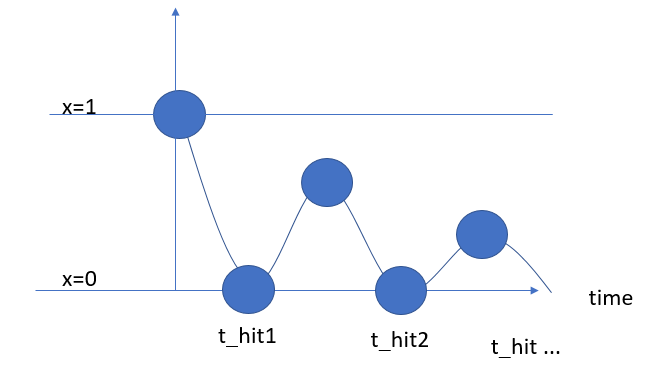

The equation of motion governing the free-fall of this ball is 

$$ m \frac{d^2 x}{dt^2} = -g m $$

where $g$ is the gravitational constant ($g=9.81$ m/s^2), and $m$ is the mass of ball. Since the mass cancels out, the equation simply becomes: 

$$ \frac{d^2 x}{dt^2} = -g$$

Instead of the position, we can write the equation in terms of velocity which is: 

$$ \frac{d v}{dt} = -g $$

Integrating the equation above yields:

$$\frac{d x}{dt} = v(t) = -g t + v_0$$

Where $v_0$ the initial velocity. At $t=0$ that velocity is 0, since the ball is dropped, but later on, when the ball bounces back it will be different from zero, except at the apex of the bounce. The position can be found by integration one more time:

$$ x(t) = -\frac{1}{2} g t^2 + v_0 t + x_0$$

where $x_0$ is the initial position of the ball. The equation is general and applies no matter where the ball is initially placed and with what velocity vector it has. To find the time at which a ball initially placed at $x=x_0$ and travelling with initial velocity vector $v_0$, we can solve the parabolic equation in $t$ for $x(t) = 0$:

$$ \Delta t_{hit} = \frac{-v_0 + \sqrt{v_0^2 + 2 g x_0}}{-g}$$

where $\Delta t_{hit}$ is the time until the the ball touces the ground. Next, we need to find an expression as function of number of bounces. For the first bounce, the ball starts at $x_0$ and $v_0=0$, since it starts at rest. Solving the time gives:

$$ \Delta t_{hit,1} = \sqrt{\frac{2 x_0}{g}} $$

When the ball hits the ground after $t=\Delta t_{hit,1}$, the velocity vector is no longer zero, as the ball has accellerated downwards due to gravity. Hence:

$$ v(\Delta t_{hit,1}) = - g \sqrt{\frac{2 x_0}{g}} $$

As the ball touces the ground, the ball bounces back up with the inverse velocity vector. However, we loose some momemtum, because of the plasticity of the bounce. If that loss is called $f$, then the next starting velocity vector will be:

$$ v_0 = -v(\Delta t_{hit,1}) (1-f) = g \sqrt{\frac{2 x_0}{g}} (1-f) $$

For the second bounce, the ball starts at $z_0=0$ travels up to its apex and falls back down. Hence solving the parabolic time equation gives the time between bounce 1 and 2 as:

$$ \Delta t_{hit,2} = 2 \sqrt{\frac{2 x_0}{g}}(1-f) $$

To find the total time, we sum $\Delta t_{hit,1}$ and $\Delta t_{hit,2}$ and find that:

$$ t_{hit,2} = \Delta t_{hit,1}+\Delta t_{hit,2} = \sqrt{\frac{2 x_0}{g}} \left (1+2(1-f) \right )$$

We can continue this way for N bounces and find that the total time for the N'th hit is:

$$ t_{hit,N} = \sqrt{\frac{2 x_0}{g}} \left (2\sum_{i=1}^N (1-f)^{i-1} -1 \right )$$

The python code for this is:










In [22]:
import numpy as np
import pandas as pd
def analytical_solution(N_hits, g=9.81, f=0.05, x0=1):
    t_hits = []
    summation = 0
    for i in range(N_hits):
        summation += (2*(1-f)**(i))
        t_hit = np.sqrt(2*x0/g)*(summation-1)
        t_hits.append(t_hit)
        
    t_hits = np.array(t_hits)        
#    t_hits.shape = (1,len(t_hits))
    return t_hits

The total time for 10 hits, when the ball starts at $x_0=1$ m with $g=9.81$ m/s^2 and $f=0.05$ then becomes:

In [23]:
t_hits=analytical_solution(N_hits=10)
pd.DataFrame(t_hits, columns=["Total time"])

,Total time
0,0.451524
1,1.309419
2,2.124419
3,2.898669
4,3.634207
5,4.332967
6,4.996790
7,5.627422
8,6.226522
9,6.795667


## Solution in Numerous engine

As numerous is a state-space solver, we need to re-write the equation system in terms of ordinary differential equations (ODEs). This can be done, since velocity and position is related through: 

$$ \frac{d v}{dt} = -g$$ and $$ \frac{d x}{dt} = v $$

Here the velocity is defined negatively if the ball moves downwards (falling), and positive if it moves upwards (bouncing). Once the ball hits the ground, due to momentum transfer and plasticity we need to inverse the velocity vector and multiply with the fractional loss $(1-f)$.

First we import all necessary modules of Numerous. The once we need for this tutorial is Item, Subsystem, Model, Simulation, the equation decorator, Equation class. For this tutorial we're also going to import pandas, numpy and plotly for visualization.

In [24]:
import sys
import os
from numerous.engine.system import Item
from numerous.engine.model import Model
from numerous.engine.system import Subsystem
from numerous.engine.simulation import Simulation
from numerous.engine.system import ConnectorTwoWay
from numerous.engine import VariableType, VariableDescription, OverloadAction


from numerous.multiphysics import EquationBase, Equation

from numerous.utils import HistoryDataFrame
from datetime import timedelta
import plotly.graph_objs as go


Now we create the equation of motion, using the EquationBase class.

In [25]:
class Bouncing(EquationBase):
    def __init__(self, g=9.81, f_loss=0.05, x=1, v=0):
        super().__init__(tag='bouncing_eq')
        self.add_constant('g', g)
        self.add_constant('f_loss', f_loss)
        self.add_parameter('t_hit', 0)
        self.add_state('x', x)
        self.add_state('v', v)        

    @Equation()
    def eval(self, scope):
        scope.x_dot = scope.v # Position
        scope.v_dot = -scope.g # Velocity
       
                   
            

The call to:
``` python 
super().__init__(tag='for info only') 
```

in `__init__` is necessary boilerplate for now. We add constants using the `EquationBase.add_constant` method. The constants we need here are the gravitational constant $g$ and the friction loss $f$, here $f_{loss}$. We also add a parameter $t_{hit}$, which we will use to keep track of when the last time the ball hit the ground. The states, which are integrated by the solver, are added using the ` EquationBase.add_state ` method. After definining the equation of motion, we need a item on which to apply this equation. We call this item `Ball `:

In [26]:
class Ball(Item):
    def __init__(self, tag="ball", g=9.81, f_loss=5, x0=1, v0=0):
        super().__init__(tag)

        t1 = self.create_namespace('t1')
        t1.add_equations([Bouncing(g=g, f_loss=f_loss, x=x0, v=v0)])   

As for the `EquationBase`, the call to `super().__init__(tag)` is necessary boilerplate code with the current release of Numerous. In the `Ball` class, we also create the namespace to contain the variables for the `Bouncing` equation. This is done using the `Item` method `Item.create_namespace`. The namespace is then associated to an equation using the `add_equations` method. Here, we add the `Bouncing` equation, and pass along the parameters $g$, $f_{loss}$, $x0$ and $v0$.

Finally, we're ready to assemble the very simple system, which takes as input the `Ball` item:

In [27]:
def ms1(simple_item):
    class S1(Subsystem):
        def __init__(self, tag):
            super().__init__(tag)
            self.register_items([simple_item])

    return S1('S1')



We can now define the system:

In [28]:
model_system_1 = ms1(Ball(tag="ball",g=9.81, f_loss=0.05))

To catch the point in time, at which the ball touches the ground we can use two approaches:
* `callback` functions. These are functions that are called each time a solver step has been completed. We can set these up to check if the ball has passed $x=0$, and then reverse its direction and reduce its velocity by the friction loss. This is a simple approach, but requires very small time-steps, which reduce in size as the ball travels less and less up and down. As a result, the calculation time can become significant.
* `event` functions. An event function uses a root-finding algorithm to detect when a certain condition is triggered. For example, if we want to determine the time at which the position is 0, then the event function needs only to return the position, since the root of that equation is at $x=0$. 

## Solving the system with `callback` functions
Let us make a `callback` function first. The arguments to a `callback` are the current time `t` and the `variables` object, which holds all model variables. Since we tagged our `Item:Ball` as 'ball', and since the namespace in `Ball` was called 't1', we can access the variables by refering to `ball.t1.v` for the velocity, and `ball.t1.x` for the position, etc. The value is obtained using the `.value` method.

In [29]:
# detect crossing after each time-step and change movement and reduce velocity, if zero crossing detected (non event)
def hitground_callback_ms1(t, variables):
    velocity = variables['S1.ball.t1.v'].value
    position = variables['S1.ball.t1.x'].value
    f_loss = variables['S1.ball.t1.f_loss'].value

    if (position <= 0) and (velocity < 0):
        variables['S1.ball.t1.t_hit'].value = t
        velocity = -velocity * (1 - f_loss)
    
    variables['S1.ball.t1.v'].value = velocity

    # This is currently not implemented
    if (velocity < 1e-3) and (position < 1e-3):
        return 1
    


In the `hitground_callback_ms1`, first we check if the position is less than, or equal to zero, and the velocity is negative, meaning the ball has touched the ground. If that is the case, we reverse the velocity vector, and reduce its value by $1-f_{loss}$. We also save the time of the ground hit in the $t_{hit}$ variable. Next, we replace velocity by the new velocity in the `variables` object, and finally we add a stop condition that if the ball is close to the ground and its velocity is not significant, the solver halts, by returning a value different than `None` (-CURRENTLY NOT IMPLEMENTED). Now we're ready to solve the system. 

In [30]:
tmax = 20
num = 1000
#num_inner = 2

def solve_model_system_fun(model_system):
    m1 = Model(model_system)                    
    m1.add_callback('hitground', hitground_callback_ms1)                    
    sim = Simulation(m1, t_start=0, t_stop=tmax, num=num, max_step=0.01)    
    sol = sim.solve()
    return sim, sol



First we create a `Model` object using the subsystem `model_system_1`defined earlier. Then we add the `callback` to the model using the `add_callback` method, which requires a name (for internal information only), and a function handle. Next, we setup a `Simulation` using `model` `m1`. The parameters `num` are used to specify the number of steps at which the solution is evaluated between `t_start` and `t_stop`. Finally by calling the `solve` method on the `Simulation` object, we obtain the solution object `sol`. The code is called below:

In [31]:
sim1, sol1 = solve_model_system_fun(model_system_1)

100%|██████████| 1000/1000 [00:03<00:00, 279.19it/s]


To plot the solution, we add the following code which uses `plotly`. We shall not go into detail on the code, but simply include it here as it's used for the purpose illustrating the results of this tutorial only.

In [32]:
class Link_x():
    def __init__(self, handles=[]):
        self.handles = handles
        for f in handles:
            f.layout.on_change(self.callback, 'xaxis.range')            
    def callback(self, layout, xrange):
        for handle in self.handles:
            handle.layout.xaxis['range'] = xrange

class Plotfig():
    def __init__(self):
        self.list = []
        
    def link_x(self):
        for f in self.list:
            f.layout.on_change(self.link_x_callback, 'xaxis.range')                    
    def link_x_callback(self, layout, xrange):         
        for f in self.list:
            f.layout.xaxis['range'] = xrange
            
    def add(self, res, y, xlabel=None, ylabel=None, avr=[False,], xlim=[None, None], ylim=[None, None]):        
        
        legend_x = 1
        legend_y = 0.5    
       
        data = []
        for yi in y:
         
            data.append(go.Scatter(x=res[yi]['time'], y=res[yi]['values'], name=yi, mode='lines'))
            if avr[0]==True:
                N = avr[1]
                y_padded = np.pad(res[yi]['values'], (N//2, N-1-N//2), mode='edge')
                yavr = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
                data.append(go.Scatter(x=res[yi]['time'], y=yavr, name=yi+'_mean_' + str(N)))

        if (xlim[0] == None) and (xlim[1] == None):    
            xautorange=True        
        else:
            xautorange=False

        if (ylim[0] == None) and (ylim[1] == None):
            yautorange=True
        else:
            yautorange=False

        layout = go.Layout(
            xaxis=dict(
                autorange=xautorange,
                range=xlim,
                showgrid=True,
                zeroline=False,
                showline=False,
                title=xlabel,
                showticklabels=True
            ),
            yaxis=dict(
                autorange=yautorange,            
                range=ylim,
                showgrid=True,
                zeroline=False,
                showline=False,
                title=ylabel,            
                showticklabels=True
            ),
            showlegend=True,
        )


        f = go.FigureWidget(data=data, layout=layout)
        
        self.list.append(f)
        return f
    def show(self):
        for f in self.list:
            f.show()
                   
class Collection():
    def __init__(self):
        self.res = {}
    def alias(self, historydataframe, y={}):
                
        for key in list(y.keys()):
            self.res.update({key: {'values': [], 'time': []}})
        
        for index, row in historydataframe.df.iterrows():            
            for tag in y:
                self.res[tag]['values'].append(row[y[tag]])    
                self.res[tag]['time'].append(index.total_seconds())

With the code in place, we can plot the solution by accessing the `Model` object `historian`, which contains a log of all variables in a `Pandas` dataframe. The `Simulation` object, `sim1` contains the `model` object and the time logged variables are accessible through `sim1.model.historian`. Accessing, and plotting the data is up to the user, but the supplied `Collection` and `Plotfig` classes can be used as is.

In [33]:
collection = Collection()
collection.alias(sim1.model.historian, y={'velocity_callback': 'S1.ball.t1.v', 'position_callback': 'S1.ball.t1.x'})
f=Plotfig()
f.add(collection.res, y=['velocity_callback'], xlabel='Time (s)', ylabel='Velocity (m/s)')
f.add(collection.res, y=['position_callback'], xlabel='Time (s)', ylabel='Position above ground (m)')
f.show()

We see that the ball accellerates downwards, starting from rest. When it hits the ground, it reverses and moves upwards with slightly lower momentum. This continues until the ball is finally at rest. We can also observe, that the ball sometimes obtains negative positions, which is of course unphysical, but a possibility due to the necessity of having to make very small time-steps to do the hit detection. 

Finally, we can get the timestamp of all hits using the `t_hit` variable, and compare it to the analytical solution. Here this is done for the first 10 hits:

In [34]:
t_hits_callback = sim1.model.historian.df['S1.ball.t1.t_hit'].unique()[1:11]
pd.DataFrame({'total time analytical': t_hits, 'total time callback': t_hits_callback, 'error': 100*(t_hits_callback-t_hits)/t_hits})


,total time analytical,total time callback,error
0,0.451524,0.46,1.877279
1,1.309419,1.34,2.335498
2,2.124419,2.18,2.616305
3,2.898669,2.98,2.805809
4,3.634207,3.74,2.911047
5,4.332967,4.46,2.931771
6,4.996790,5.14,2.866039
7,5.627422,5.78,2.711337
8,6.226522,6.38,2.464913
9,6.795667,6.94,2.123902


## Solving the system with `event` functions
Now that we've demonstrated the callback functions, we're going to do the same with `event` functions. `Event` functions use the solver's (`scipy.integrate.solve_ivp`) build in event detection algorithm, which uses a root finding method to detect when a event has been triggered. Numerous expands upon this by adding `event callbacks` which are functions that are called if and only if an event is triggered. The `event callbacks` are bound to an `event` and multiple `callbacks` can be bound to a single event. Multiple `events` can be bound to a model as well, for example to detect the apex of the bouncing ball. Let us first define the `event` function, which catches whenever the ball hits the ground. The event function must be written of the type $f(t, variables) = 0$, when the event is triggered. Since we're using the position, the root of that function is when $x=0$ so:

In [35]:
# returns position to find zero crossing using root finding algorithm of scipy solver
def hitground_event_fun(t, variables):
    return variables['S1.ball.t1.x'].value

hitground_event_fun.direction = -1




We use monkey-patching to set the direction trigger from positive to negative (ball moves past ground), by setting the `direction` attribute to -1. Next, once the event is triggered, we with to reverse the direction of the ball, much similar to the `callback` example above:

In [36]:
# change direction of movement upon event detection and reduce velocity
def hitground_event_callback_fun(t, variables):

    #print("calling event: " + str(t))
    velocity = variables['S1.ball.t1.v'].value
    velocity = -velocity * (1 - variables['S1.ball.t1.f_loss'].value)
    variables['S1.ball.t1.v'].value = velocity
    variables['S1.ball.t1.t_hit'].value = t
    


As before, we want to halt the simulation if an event (`hitground_event_fun`) is triggered and the ball hardly moves, so the function returns 1 in that case. We are now ready to solve the system:

In [37]:
model_system_2 = ms1(Ball(tag="ball",g=9.81, f_loss=0.05))



In [38]:
def solve_model_system_event_fun(model_system):            
    m1 = Model(model_system)
    
    m1.add_event("hitground_event", hitground_event_fun)
    m1.add_event_callback("hitground_event", hitground_event_callback_fun)        
    
    sim = Simulation(m1, t_start=0, t_stop=tmax, num=num)
    
    sol = sim.solve()
    return sim, sol


#s1,sol1  = solve_model_system_fun(model_system_1)




In the function above, we create a `Model` object on the subsystem `ms1`, then we add an event function using the `add_event` method, and associate an event callback to that event function using the `add_event_callback` method. Multiple callbacks can be added to a single event, and multiple events can be added to a single model, but here we're only looking at a single `event` with a single `callback` function defined. Next, the system is solved:

In [39]:
sim2,sol2  = solve_model_system_event_fun(model_system_2)

 88%|████████▊ | 878/1000 [00:03<00:00, 239.65it/s]


In [40]:
collection.alias(sim2.model.historian, y={'velocity_event': 'S1.ball.t1.v', 'position_event': 'S1.ball.t1.x'})
f=Plotfig()
f.add(collection.res, y=['velocity_event'], xlabel='Time (s)', ylabel='Velocity (m/s)')
f.add(collection.res, y=['position_event'], xlabel='Time (s)', ylabel='Position (m)')
f.link_x()
f.show()


As opposed to the `callback` method earlier, we can observe that the position no longer drops below 0. We can now compare the analytical solution to that which can obtained by the `event` functions:

In [41]:
t_hits_event = sim2.model.historian.df['S1.ball.t1.t_hit'].unique()[1:11]
pd.DataFrame({'total time analytical': t_hits, 'total time event': t_hits_event, 'error': 100*(t_hits_event-t_hits)/t_hits})


,total time analytical,total time event,error
0,0.451524,0.451524,-8.605929e-14
1,1.309419,1.309419,-1.187025e-13
2,2.124419,2.124419,-1.254242e-13
3,2.898669,2.898669,-1.225636e-13
4,3.634207,3.634207,-1.221970e-13
5,4.332967,4.332967,4.099631e-14
6,4.996790,4.996790,3.021747e-13
7,5.627422,5.627422,4.892744e-13
8,6.226522,6.226522,6.418998e-13
9,6.795667,6.795667,7.711168e-13


Clearly, an improvement in precision to a very high degree of accuracy.

## Use cases for `event` and `callback` functions

This tutorial demonstrated the use of `callback` functions, and `event` functions with associated `event callbacks`. Using `event` functions has the disadvantage of having to solve for the roots in the `event` function equation for each time-step, which can add overhead time. On the other hand, if precision is required, we need to reduce step size quite dramatically when using simple `callback` functions. It is clear, that the the precise detection of certain triggers is done best using `event` and `event callbacks`, but in other cases where that precision is not needed, we can quite easily use `callback` functions, which can reduce that overhead.

For example, if we model a state, which is used as input in a PID controller, and the dynamics of that changing that state is relatively slow (example could be a boiler with a heating element controlled to a certain temperature), then we can use `callback` functions to model the PID controller. Nevertheless, a clear strategy cannot be given a-priori, and it is best up to the simulation expert to determine whether or not to use `event` functions or `callback` functions, and best of all Numerous allows both.

In [ ]:
sim2.model.historian.df